In [1]:
pip --version

pip 20.0.2 from /Users/jbanerje/opt/anaconda3/lib/python3.7/site-packages/pip (python 3.7)
Note: you may need to restart the kernel to use updated packages.


In [2]:
%%capture
pip install prometheus-api-client

In [3]:
%%capture
pip install matplotlib

In [4]:
from prometheus_api_client import *
import matplotlib.pyplot as plt
import os
import numpy as np
import sys
import datetime
import pandas
import seaborn as sns
# Set default Seaborn style
sns.set(style="darkgrid")
sns.set_context("talk", font_scale=1.4)
## hides ipython warnings
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (30, 10)
#plt.rcParams['figure.figsize'] = (20, 5)

# Analysing Alert data out of ACM Observability :

This is combination of 2 other notebooks in this repository:
- https://github.com/bjoydeep/multicluster-notebooks/blob/main/alert_analyzer.ipynb
- https://github.com/bjoydeep/multicluster-notebooks/blob/main/alert_collector.ipynb

## To set up

1. Install ACM and Observability
1. Get URL of the route called rbac-query-proxy created in namespace:open-cluster-management-observability
1. Get the bearer token of the logged in user
1. Select the time range in the cell below

## If you run this notebook
1. It will analyze alerts received from different clusters and try to find out patterns



### Sets the connection details

In [5]:
# URL of the route call rbac-query-proxy 
# created in namespace:open-cluster-management-observability
# after installing Observability on Advanaced Cluster Managment Install
#url = "https://rbac-query-proxy-open-cluster-management-observability.apps.xyz.redhat.com/"
url = "https://rbac-query-proxy-open-cluster-management-observability.apps.jbanerje-48fc8-lmvt9.dev05.red-chesterfield.com"
# bearer token obtained from command `oc whoami -t`
#token = "sha256~5AyxhxNb4voPuT0galw4X-abcd1234xyz"
token = "eyJhbGciOiJSUzI1NiIsImtpZCI6IkZVWHNScjV6eHlKVVlET0FDVUZUZzAyYU9lQURJRGpfa3Z1MTR2VF90OGsifQ.eyJpc3MiOiJrdWJlcm5ldGVzL3NlcnZpY2VhY2NvdW50Iiwia3ViZXJuZXRlcy5pby9zZXJ2aWNlYWNjb3VudC9uYW1lc3BhY2UiOiJvcGVuLWNsdXN0ZXItbWFuYWdlbWVudCIsImt1YmVybmV0ZXMuaW8vc2VydmljZWFjY291bnQvc2VjcmV0Lm5hbWUiOiJtdWx0aWNsdXN0ZXItb2JzZXJ2YWJpbGl0eS1vcGVyYXRvci10b2tlbi14OTlxNiIsImt1YmVybmV0ZXMuaW8vc2VydmljZWFjY291bnQvc2VydmljZS1hY2NvdW50Lm5hbWUiOiJtdWx0aWNsdXN0ZXItb2JzZXJ2YWJpbGl0eS1vcGVyYXRvciIsImt1YmVybmV0ZXMuaW8vc2VydmljZWFjY291bnQvc2VydmljZS1hY2NvdW50LnVpZCI6ImUzZTU4OGNlLTdhMGUtNGVmNy1iM2Y5LTZkODc0YTBmYTVjNyIsInN1YiI6InN5c3RlbTpzZXJ2aWNlYWNjb3VudDpvcGVuLWNsdXN0ZXItbWFuYWdlbWVudDptdWx0aWNsdXN0ZXItb2JzZXJ2YWJpbGl0eS1vcGVyYXRvciJ9.dNyL3clDpI2hTUDpiZOgmFpNqeuln5u668hCuT3UNn5j530ktsSs3AzmEQYyBk0ct3G8n6K9OYTDUOFQ6UoQdZvcorbDqlwRwjHJ_TCtb1g_dsQ8BWnd9SfZp4BVgXCAbn4kim-aAM1KRzTEvzRRyIxcg3UMG2vEiDS3dspxixuaTq6JTNdvX_-Q85GsLdqAv0kTzFrb5Yhlva-5w7rJFewN12JdU7rD4DhZ9Kajjo7aVMmQ19xRGrbcsvcuiQIGg9QXDZEyae18ZNib-Z3odT6qyGSIQRzADZju2Qptx7Do81RRJw1E3VVMIXxBJqhEOmwhagMLHwcTJSau6YQpfqBhvTQjGgUkXaQee902Wij_DM4f4Yn-d0BSzpT3vy12d1DQ6zIWLK4N8nhBHp8phpjfTsrJU8ve3hWubd2IxkPYrzOU_Sb6b8pp2UmlyZlce-x2_ikfaTU3ClXj7gKmsFbYyFJEwl21lFkBxTBn3_yZITjzlJGSpEOrLiGALfcG1gHvcPHWCGksvVnzwRN4AKznlqlsetWReI3L6P0xV_nk9OApiJWp2NBNTk2FlS_LsH7_Mr4qWw-iX7WaSoOt00MLh9DH1uN7l_EqlBdS7XVfXlAy4gXRssdGxpNVTNVIR-HM-l9ttV1ZyIpaWu62g7X5L8u6XYyF2IjcnPVxpVQ"
#connects to Thanos or Prometheus as dictated by the URL
pc = PrometheusConnect(url=url, headers={"Authorization": "Bearer {}".format(token)}, disable_ssl=True);

### Sets the time range and time step for all queries below

In [6]:
start_time=(datetime.datetime.now() - datetime.timedelta(minutes=2160))
end_time=datetime.datetime.now()
#interval between data points gathered
step='10m'

### Runs Query and Gather data

In [7]:
# PromQL being run: count(ALERTS{alertstate="firing"}) by (cluster,alertname)
alert_total = pc.custom_query_range(
    query='count(ALERTS{alertstate="firing"}) by (cluster,alertname)',
    start_time=start_time,
    end_time=end_time,
    step=step,
)

alert_total_df = MetricRangeDataFrame(alert_total);
alert_total_df["value"]=alert_total_df["value"].astype(float)
alert_total_df.index= pandas.to_datetime(alert_total_df.index, unit="s")

print(alert_total_df.head())
print(alert_total_df.count())




                                           alertname        cluster  value
timestamp                                                                 
2021-09-01 16:10:00  APIRemovedInNextEUSReleaseInUse  local-cluster    4.0
2021-09-01 16:20:00  APIRemovedInNextEUSReleaseInUse  local-cluster    4.0
2021-09-01 16:30:00  APIRemovedInNextEUSReleaseInUse  local-cluster    4.0
2021-09-01 16:40:00  APIRemovedInNextEUSReleaseInUse  local-cluster    4.0
2021-09-01 16:50:00  APIRemovedInNextEUSReleaseInUse  local-cluster    4.0
alertname    733
cluster      685
value        733
dtype: int64


### Total Number of Alerts by time

timestamp
2021-09-01 16:10:00    11.0
2021-09-01 16:20:00    11.0
2021-09-01 16:30:00    11.0
2021-09-01 16:40:00    11.0
2021-09-01 16:50:00    11.0
Name: value, dtype: float64


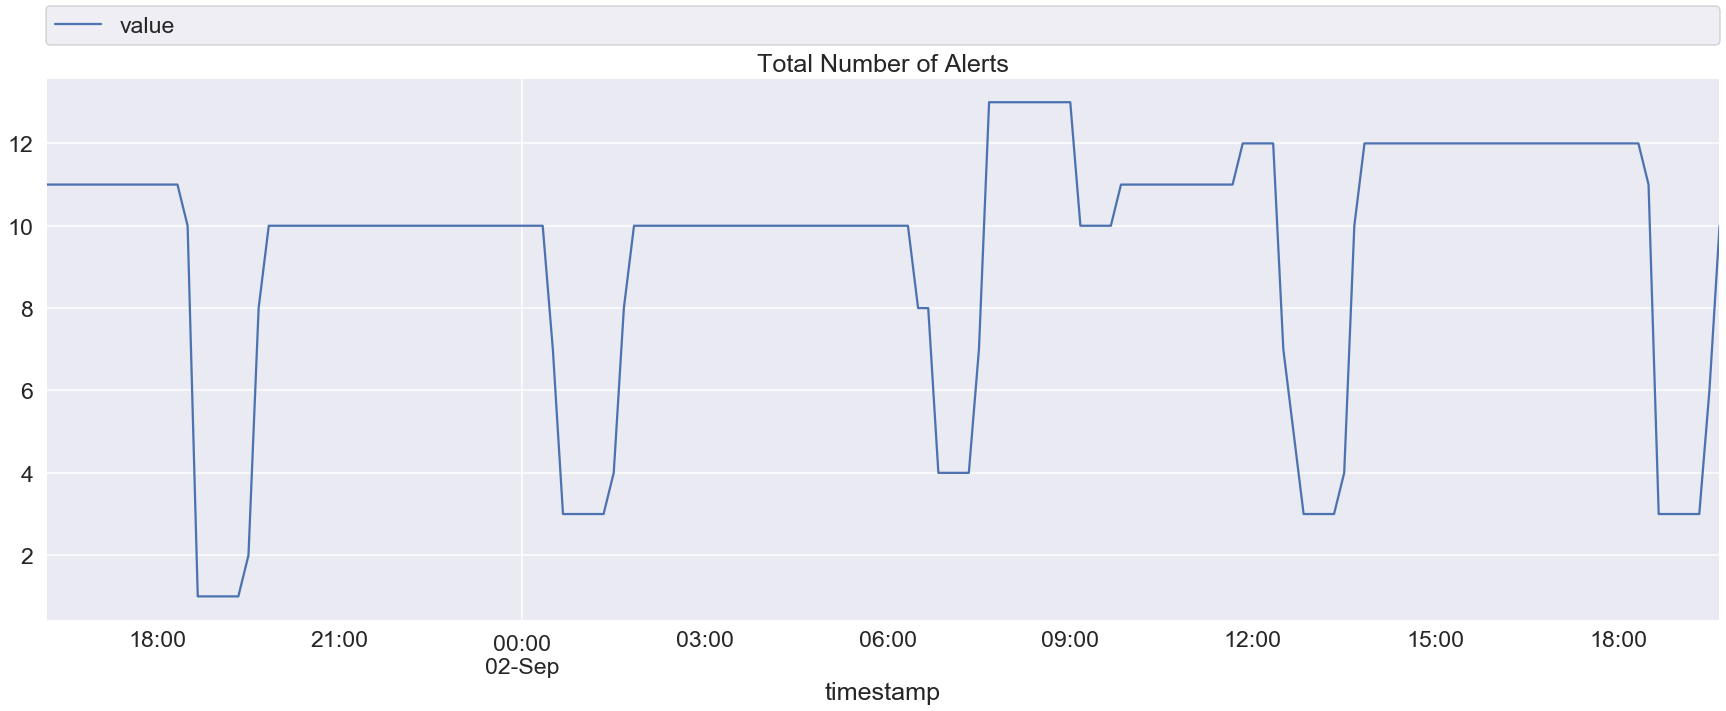

In [8]:
alert_count_df = alert_total_df.groupby(["timestamp"])["value"].sum()
print(alert_count_df.head())
ax=alert_count_df.plot(title="Total Number of Alerts")
ax.legend(bbox_to_anchor=(0., 1.06, 1., .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0.)
plt.show()

### Number of Alerts by Cluster by time

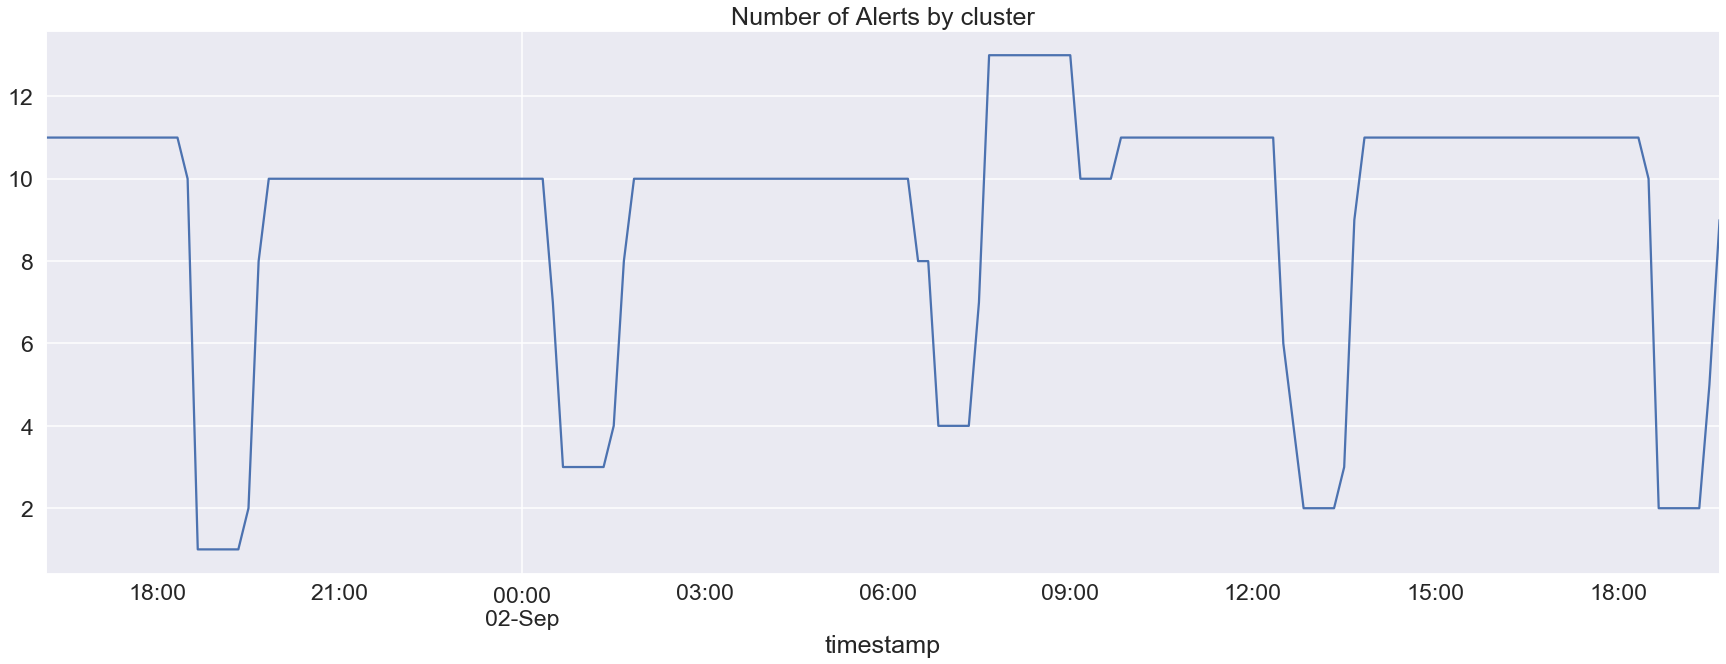

In [9]:
alert_cluster_df = alert_total_df.groupby(["cluster","timestamp"])["value"].sum()
alert_cluster_df=alert_cluster_df.unstack(level=0)
#print(alert_cluster_df.head())
ax=alert_cluster_df.plot(title="Number of Alerts by cluster")
ax.legend(bbox_to_anchor=(0., 1.06, 1., .102), loc='lower left', ncol=6, mode="expand", borderaxespad=0.)
#just removing the legend from being print
#its meaningless to show 1k labels
ax.get_legend().remove()
plt.show()

### Number of different Alerts by time

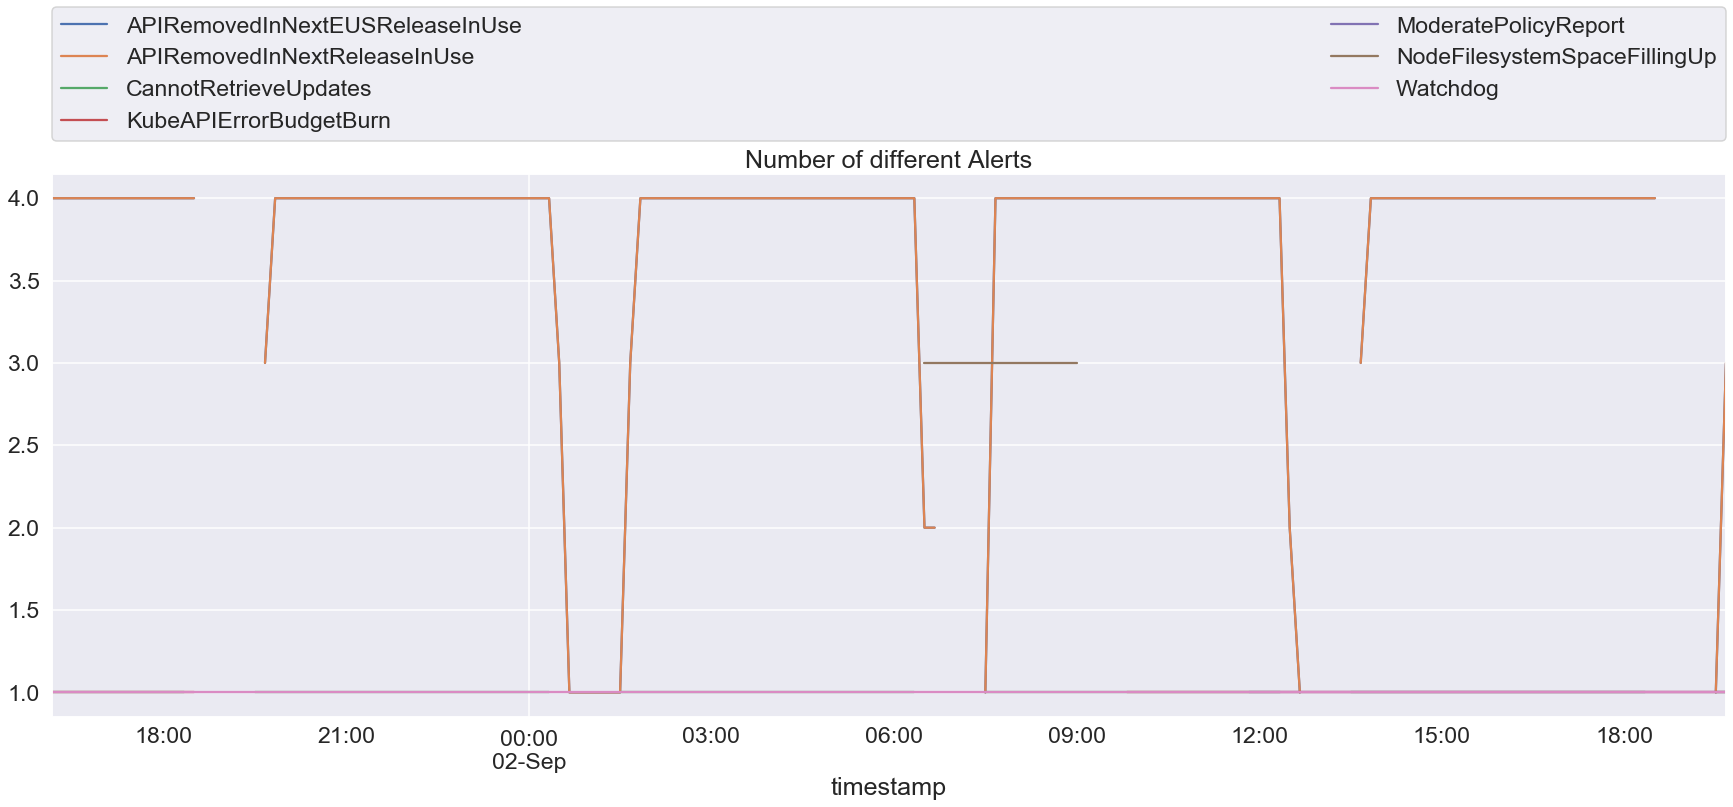

In [10]:
alert_alert_df = alert_total_df.groupby(["alertname","timestamp"])["value"].sum()
alert_alert_df=alert_alert_df.unstack(level=0)
#print(alert_alert_df.head())
ax=alert_alert_df.plot(title="Number of different Alerts")
ax.legend(bbox_to_anchor=(0., 1.06, 1., .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0.)
plt.show()

### Highest Grossing Alerts

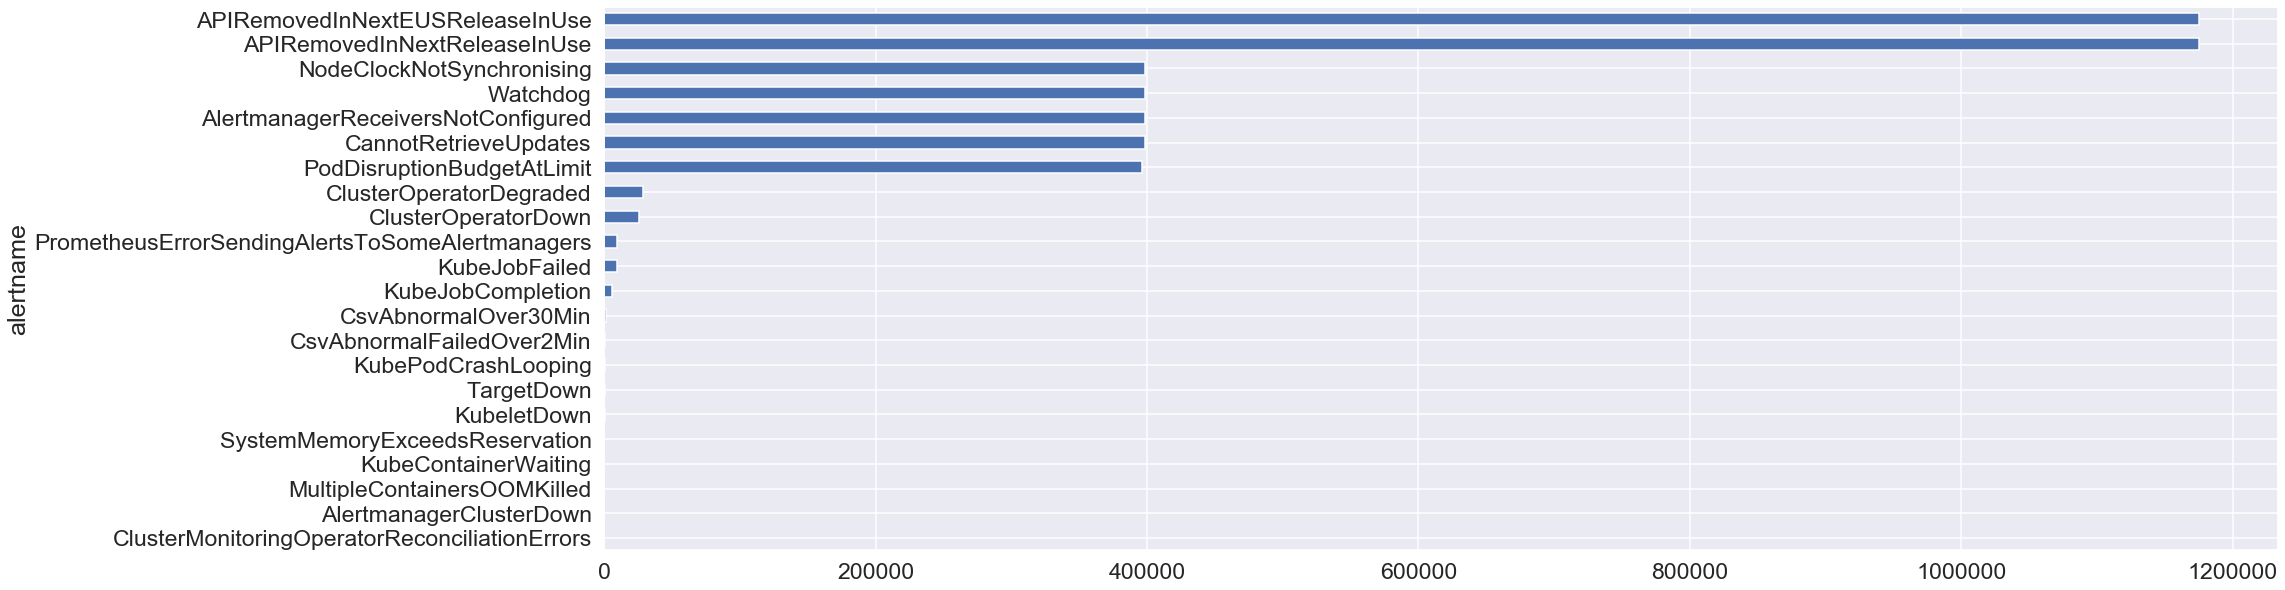

In [11]:
alert_slice_df = alert_total_df.groupby(["alertname"])["value"].sum()
#print(alert_slice_df.dtypes)
#plt.pie(alert_slice_df, labels = alert_slice_df["alertname"])
#plt.legend(title = "AlertName")
#plt.show()

ax = alert_slice_df.sort_values(ascending=True).plot.barh(x='alertname', y='value', rot=0)
#ax = alert_slice_df.plot.barh(x='alertname', y='value', rot=0)


#pandas.DataFrame.plot(data=alert_slice_df, y="value", kind='pie',  autopct='%.2f', labels=None,  ax=ax, title="ll", fontsize=10)
#ax.legend(loc=3, labels=alert_slice_df.index)

#ax = alert_slice_df.plot.pie(y="value",labels=None)
#ax.legend(labels, bbox_to_anchor=(0., 1.06, 1., .102), loc='lower left', ncol=1, mode="expand", borderaxespad=0.)


### Heatmap of clusters and Alerts

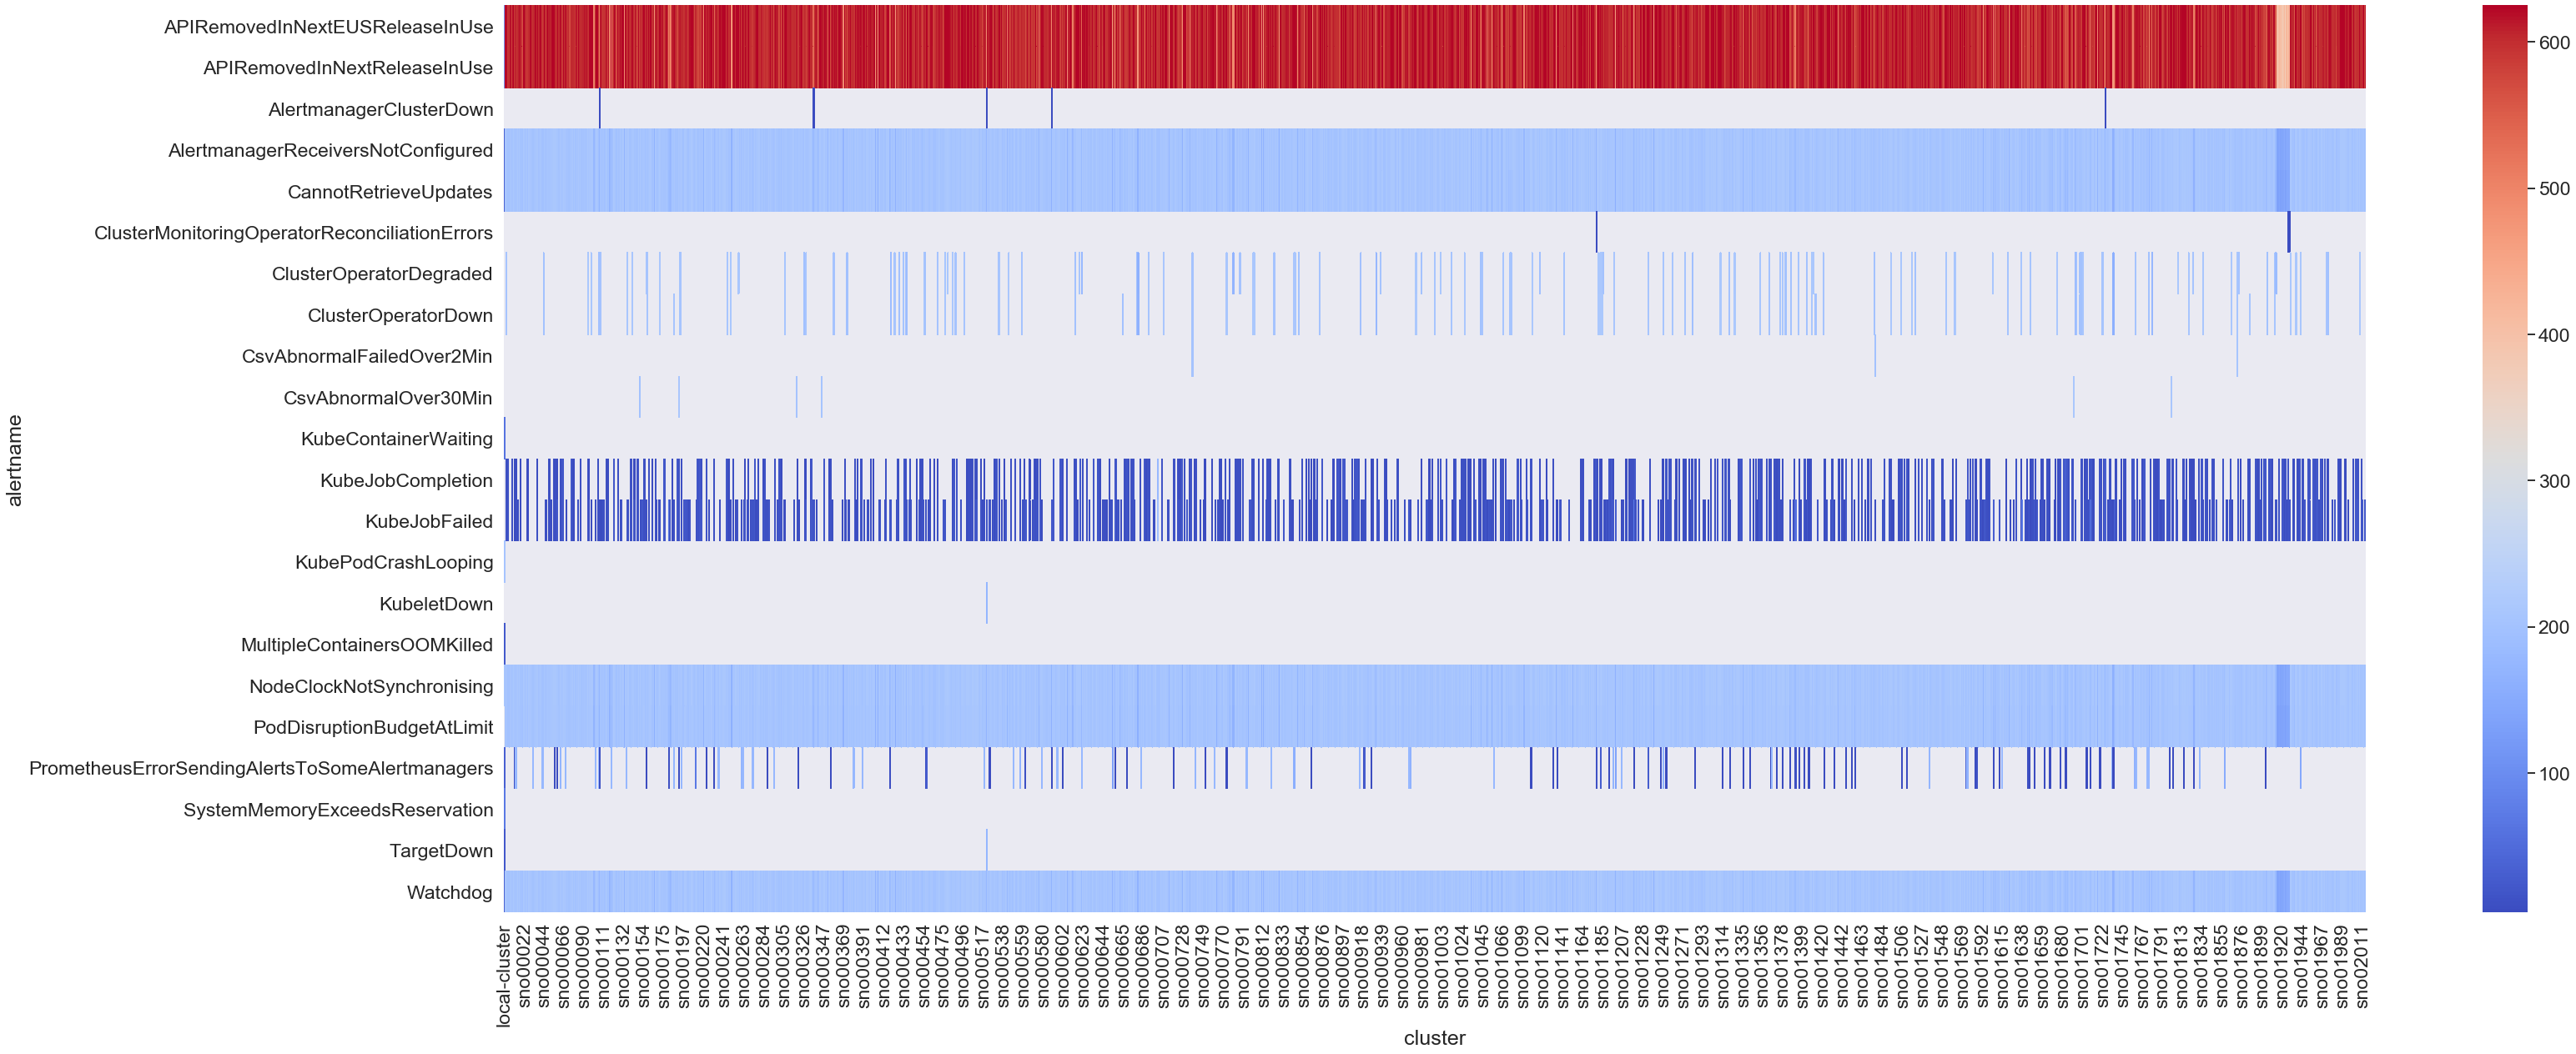

In [12]:
alert_cluster_scatter = alert_total_df.groupby(["cluster","alertname"])["value"].sum()
#print(alert_cluster_scatter.head())
#vmax = alert_cluster_scatter.values.min()
#vmin = alert_cluster_scatter.values.max()
#midpoint = (alert_cluster_scatter.values.min() - alert_cluster_scatter.values.max())/2

alert_cluster_scatter=alert_cluster_scatter.unstack(level=0)

fig, ax = plt.subplots(figsize=(50, 20))
#alert_cluster_scatter.set_xticks(np.arange(len(alert_total_df["cluster"])))

#alert_cluster_scatter.set_xticks(np.arange(len(alert_total_df["cluster"])))
#sns.heatmap(alert_cluster_scatter, cmap='coolwarm', center=midpoint)
# robust = True seems to be a good choice to remove noise. 
# sets contrast levels based on quantiles and works like an “auto-contrast” for choosing good values
ax=sns.heatmap(alert_cluster_scatter, cmap='coolwarm', robust=True)
#print(len(alert_total_df["cluster"].unique()))
ax.set_xticks=(len(alert_total_df["cluster"].unique()))
plt.show()

### Heatmap of clusters and Alerts with Alternate Visualization

In [13]:
#importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True,dimensions=(6000,700))

alert_cluster_scatter = alert_total_df.groupby(["alertname","cluster"])["value"].sum()
alert_cluster_scatter=alert_cluster_scatter.unstack(level=0)

alert_cluster_scatter.iplot(kind='heatmap',colorscale="Oranges",
                            title="HeatMap of Alerts across Clusters", xTitle="Clusters")